In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

In [2]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [3]:
# https://numpy.org/devdocs/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4, legacy='1.25')


Find the equally-weighted risk contribution (EWRC) portfolios for two samples:

- Daily returns data from Yahoo! Finance with the following tickers: `SPY SLYV SPDW IEF TLT GLD DBC`
- Annual returns data from Aswath Damodaran available here: <https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls>. Use data starting in 1928 and the "Annual Returns on Investments in" section. You will need to use `pd.read_excel()` with the correct arguments to skip the header and only read the relvant data.

Briefly analyze and discuss your findings, including:

- Balanced (60/40), risk parity, and leveraged risk parity (to match balanced portfolio volatility) portfolio
- Compare total returns, mean returns, geometric mean returns, volatility of returns, Sharpe ratios, and maximum draw downs
- Discuss limitations of each portfolio and your findings

In [4]:
## Daily Returns Data

In [5]:
tickers = ['SPY', 'SLYV', 'SPDW', 'IEF', 'TLT', 'GLD', 'DBC']
df = (
    yf.download(tickers=tickers)['Adj Close'].pct_change().dropna().rename_axis(columns='Ticker'))
df.index = df.index.tz_localize(None)

df = (
    df.join(
    pdr.DataReader(
            data_source='famafrench',
            name='F-F_Research_Data_Factors_daily',
            start='1900'
        )[0].div(100),
        how='inner'
    )
    .rename_axis(columns='Ticker')
)
df

[*********************100%***********************]  7 of 7 completed
C:\Users\r.herron\AppData\Local\Temp\ipykernel_58352\1805702748.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


Ticker,DBC,GLD,IEF,SLYV,SPDW,SPY,TLT,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,
2007-04-27,0.005064,0.010318,0.000000,-0.003040,0.000306,-0.000802,-0.000229,-0.0013,-0.0030,-0.0041,0.00022
2007-04-30,-0.008915,-0.006957,0.004342,-0.015646,-0.002447,-0.008293,0.010475,-0.0093,-0.0088,-0.0003,0.00022
2007-05-01,0.001955,-0.005962,0.000048,0.002559,-0.002760,0.002562,0.000723,0.0022,-0.0006,-0.0003,0.00018
2007-05-02,-0.007806,-0.000450,-0.001206,0.011958,0.005535,0.005852,-0.000565,0.0079,0.0062,0.0003,0.00018
2007-05-03,0.004721,0.012451,-0.001086,0.002655,0.000306,0.005417,-0.002260,0.0037,-0.0034,0.0015,0.00018
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,0.010332,0.003189,-0.001227,0.000579,-0.004039,-0.002384,-0.002541,-0.0034,0.0010,0.0016,0.00022
2024-08-27,-0.004891,0.002707,-0.000410,-0.007174,0.004325,0.001373,-0.001732,0.0006,-0.0086,0.0002,0.00022
2024-08-28,-0.012064,-0.007027,-0.000512,-0.000466,-0.005922,-0.005805,-0.001225,-0.0067,-0.0055,0.0114,0.00022


## Annual Returns Data

In [6]:

# annual_returns = pd.read_excel('/Users/sumitttt/Downloads/histretSP.xls', sheet_name = 'Returns by year', skiprows=19, usecols="A:G", index_col=0, nrows=96)
annual_returns = pd.read_excel('../histretSP.xls', sheet_name = 'Returns by year', skiprows=19, usecols="A:G", index_col=0, nrows=96)
annual_returns

,S&P 500 (includes dividends),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*
Year,,,,,,
1928,0.438112,0.030800,0.008355,0.032196,0.014911,0.000969
1929,-0.082979,0.031600,0.042038,0.030179,-0.020568,-0.001452
1930,-0.251236,0.045500,0.045409,0.005398,-0.043000,0.000969
1931,-0.438375,0.023100,-0.025589,-0.156808,-0.081505,-0.173850
1932,-0.086424,0.010700,0.087903,0.235896,-0.104664,0.212778
...,...,...,...,...,...,...
2019,0.312117,0.020625,0.096356,0.152478,0.036858,0.190774
2020,0.180232,0.003547,0.113319,0.106012,0.104321,0.241694
2021,0.284689,0.000450,-0.044160,0.009334,0.188750,-0.037544


In [7]:
def calc_rc(w, Sigma):
    return (w * (Sigma @ w)) / (w.T @ Sigma @ w)

In [8]:
def f(w, Sigma):
    ratio = (w.T @ Sigma @ w) / ((Sigma @ w) * w.shape[0])
    return ((w - ratio)**2).sum()

In [9]:
# Calculating weights of the daily return portfolio 


Sigma = df[['SPY', 'SLYV', 'SPDW', 'IEF', 'TLT', 'GLD', 'DBC']].cov()
w = np.ones(Sigma.shape[0]) / Sigma.shape[0]

result_rp1 = minimize(
    fun=f,
    x0=w,
    args=(Sigma,),
    bounds=((0,1) for i in w),
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)
result_rp1['x']

array([0.0955, 0.079 , 0.0798, 0.3503, 0.177 , 0.1138, 0.1047])

In [10]:
# Calculating risk contribution of the daily return portfolio 
calc_rc(result_rp1['x'], Sigma)

Ticker
SPY     0.142585
SLYV    0.142849
SPDW    0.142860
IEF     0.142829
TLT     0.142961
GLD     0.143027
DBC     0.142888
dtype: float64

In [11]:
annual_returns.columns

Index(['S&P 500 (includes dividends)', '3-month T.Bill',
       'US T. Bond (10-year)', ' Baa Corporate Bond', 'Real Estate', 'Gold*'],
      dtype='object')

In [12]:
# Calculating weights of the annual return portfolio (Aswath Damodaran)

Sigma = annual_returns[['S&P 500 (includes dividends)', '3-month T.Bill',
       'US T. Bond (10-year)', ' Baa Corporate Bond', 'Real Estate', 'Gold*']].cov()
w = np.ones(Sigma.shape[0]) / Sigma.shape[0]

result_rp2 = minimize(
    fun=f,
    x0=w,
    args=(Sigma,),
    bounds=((0,1) for i in w),
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)
result_rp2['x']

array([0.0638, 0.3901, 0.1414, 0.1221, 0.2165, 0.0662])

In [13]:
# Calculating risk contribution of the annual return portfolio (Aswath Damodaran)

calc_rc(result_rp2['x'], Sigma)

S&P 500 (includes dividends)    0.165946
3-month T.Bill                  0.166757
US T. Bond (10-year)            0.166770
 Baa Corporate Bond             0.166736
Real Estate                     0.166949
Gold*                           0.166843
dtype: float64

In [14]:
## Workings for Portfolio 1 - Daily return - (Balanced (60/40), risk parity, and leveraged risk parity portfolio)

In [15]:
df = (
    df.assign(
        B=lambda x: 0.6*x['SPY'] + 0.4*x['IEF'],
        RP=lambda x: x[['SPY', 'SLYV', 'SPDW', 'IEF', 'TLT', 'GLD', 'DBC']].dot(result_rp1['x']),
        RPL=lambda x: x['RP'] * (x['B'].std() / x['RP'].std()) + x['RF'] * (1 - x['B'].std() / x['RP'].std())
    )
)

In [16]:
df[['B', 'RP', 'RPL']].describe()

Ticker,B,RP,RPL
count,4367.000000,4367.000000,4367.000000
mean,0.000332,0.000225,0.000314
std,0.007191,0.004799,0.007191
min,-0.057203,-0.038091,-0.057101
25%,-0.002527,-0.002227,-0.003344
50%,0.000531,0.000365,0.000520
75%,0.003576,0.002754,0.004112
max,0.084381,0.032933,0.049302


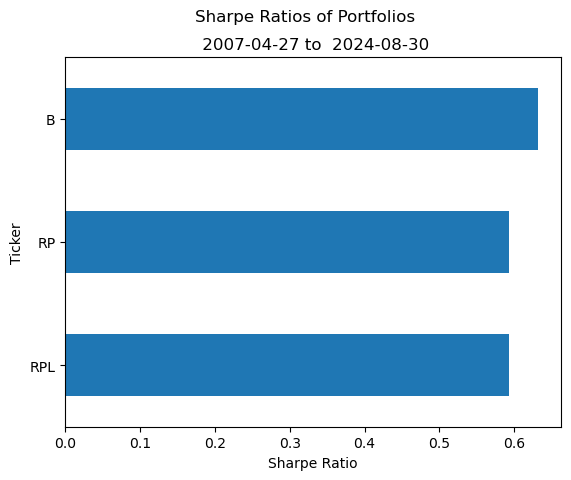

In [17]:
 (df[['B', 'RP', 'RPL']].sub(df['RF'], axis=0).apply(lambda x: np.sqrt(252) * x.mean() / x.std())
    .plot(kind='barh')
)

plt.gca().invert_yaxis()
plt.xlabel('Sharpe Ratio')
plt.suptitle('Sharpe Ratios of Portfolios')
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

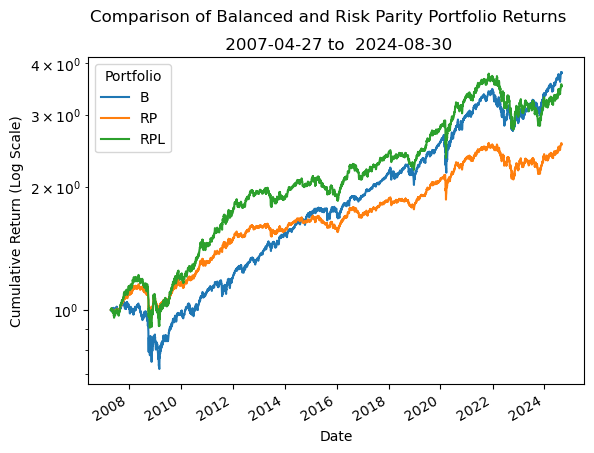

In [18]:
(
    df
    [['B', 'RP', 'RPL']]
    .rename_axis(columns='Portfolio')
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of Balanced and Risk Parity Portfolio Returns')
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

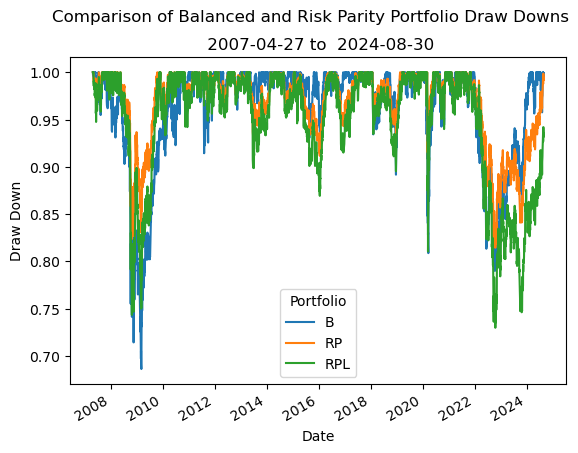

In [19]:
cumprod = df[['B', 'RP', 'RPL']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('Comparison of Balanced and Risk Parity Portfolio Draw Downs')
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

In [20]:
## Working on Portfolio 2 - Aswath Damodaran - (Balanced (60/40), risk parity, and leveraged risk parity portfolio)

In [21]:
annual_returns = (
    annual_returns.assign(
        B=lambda x: 0.6*x['S&P 500 (includes dividends)'] + 0.4*x['US T. Bond (10-year)'],
        RP=lambda x: x[['S&P 500 (includes dividends)', '3-month T.Bill',
       'US T. Bond (10-year)', ' Baa Corporate Bond', 'Real Estate', 'Gold*']].dot(result_rp2['x']),
        RPL=lambda x: x['RP'] * (x['B'].std() / x['RP'].std()) + x['3-month T.Bill'] * (1 - x['B'].std() / x['RP'].std())
    )
)

In [22]:
annual_returns[['B', 'RP', 'RPL']].describe()

,B,RP,RPL
count,96.000000,96.000000,96.000000
mean,0.089382,0.049719,0.088769
std,0.122245,0.036052,0.105382
min,-0.273261,-0.070858,-0.295488
25%,0.010629,0.031715,0.035041
50%,0.109187,0.048710,0.086064
75%,0.168961,0.071291,0.159665
max,0.328539,0.163032,0.312429


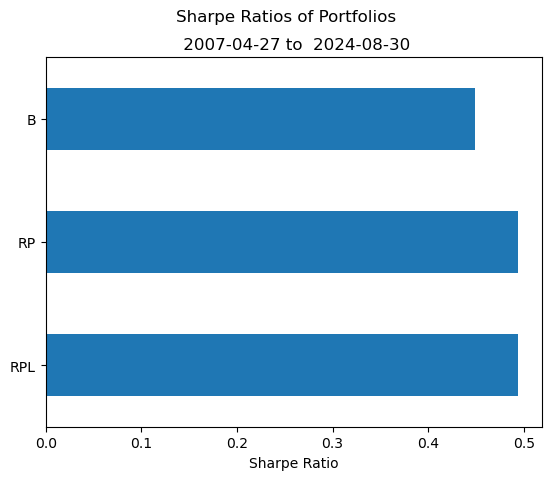

In [23]:
 (annual_returns[['B', 'RP', 'RPL']].sub(annual_returns['3-month T.Bill'], axis=0).apply(lambda x: x.mean() / x.std())
    .plot(kind='barh')
)

plt.gca().invert_yaxis()
plt.xlabel('Sharpe Ratio')
plt.suptitle('Sharpe Ratios of Portfolios')
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

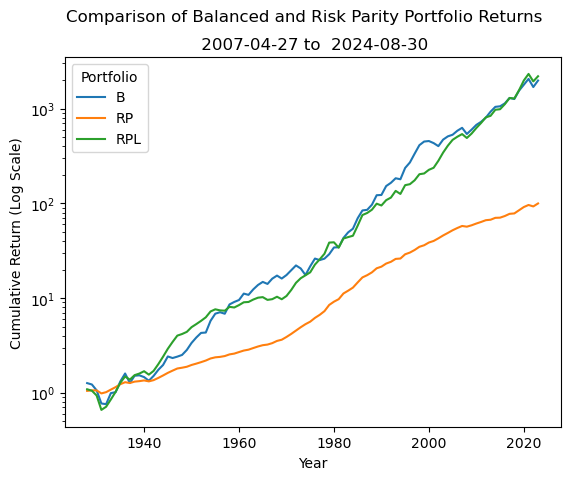

In [24]:
(
    annual_returns
    [['B', 'RP', 'RPL']]
    .rename_axis(columns='Portfolio')
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of Balanced and Risk Parity Portfolio Returns')
#! Update these dates
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

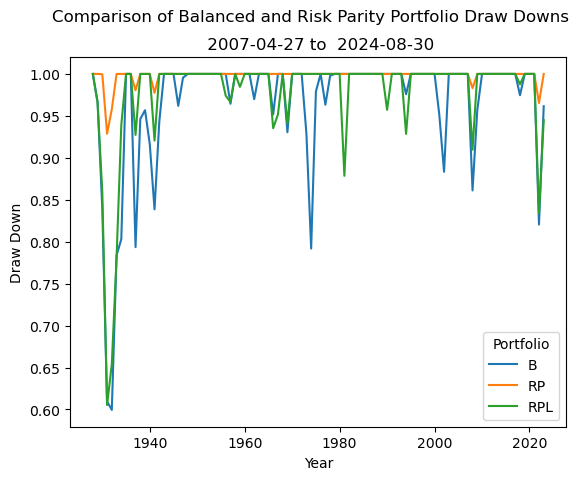

In [25]:
cumprod = annual_returns[['B', 'RP', 'RPL']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('Comparison of Balanced and Risk Parity Portfolio Draw Downs')
plt.title(f'{df.index[0]: %Y-%m-%d} to {df.index[-1]: %Y-%m-%d}')
plt.show()

In [26]:
#! Well done! Thanks for taking a risk on a one-credit course! Please let me know if you have any questions or want to review anything.
